Titanic Dataset is used for this anonymization task.

In [18]:
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels as sm
from math import floor
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
# Multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
# Import label encoder 
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

In [20]:
df = pd.read_csv("Titanic-Dataset.csv")
df.shape
df.head()

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
# Dropping columns because unique for every row
df.drop(columns=["PassengerId", "Name"], inplace=True) 
# Dropping columns because almost unique for every row
df.drop(columns=["Ticket", "Cabin"], inplace=True) 
df.dropna(inplace=True)
df.shape
df.head()

(712, 8)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [22]:
# Create the LabelEncoders
label_encoders = {
    'Sex': LabelEncoder(),
    'Embarked': LabelEncoder()
}

# Apply the LabelEncoders to the respective columns
for column, encoder in label_encoders.items():
    df[column] = encoder.fit_transform(df[column])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [23]:
df.nunique()

Survived      2
Pclass        3
Sex           2
Age          88
SibSp         6
Parch         7
Fare        219
Embarked      3
dtype: int64

In [24]:
# Survived, Pclass, Sex, SibSp, Parch,Embarked are assumed to be categorical
# Age and Fare are continuous
categorical = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
continuous = ['Age', 'Fare']

In [25]:
# Generate 5 random samples based on the distribution of the original data. 
for c in categorical:
        counts = df[c].value_counts()
        np.random.choice(list(counts.index), p=(counts/len(df)).values, size=5)

array([0, 1, 0, 0, 1])

array([1, 2, 3, 2, 2])

array([1, 1, 1, 0, 1])

array([0, 0, 0, 1, 0])

array([0, 0, 0, 0, 0])

array([0, 2, 0, 0, 2])

In [26]:
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    # Distributions to check
    DISTRIBUTIONS = [
        st.alpha, st.arcsine, st.beta, st.betaprime, st.bradford, st.burr, st.cauchy, st.chi, st.chi2, st.cosine, st.fisk,
        st.gamma, st.gengamma, st.genhalflogistic, st.halfcauchy, st.halflogistic, st.halfnorm, st.invgamma, st.invgauss,
        st.invweibull, st.logistic, st.loggamma, st.loglaplace, st.lognorm, st.lomax, st.nakagami, st.ncx2, st.ncf,
        st.norm, st.pareto, st.pearson3, st.powerlaw, st.powerlognorm, st.powernorm, st.rdist, st.reciprocal,
        st.rayleigh, st.uniform, st.wald, st.weibull_min, st.weibull_max, st.wrapcauchy
    ]
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                params = distribution.fit(data)
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                if ax:
                    pd.Series(pdf, x).plot(ax=ax)

                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def plot_result(df, continuous, cts_best_distributions):
    for c, (best_fit_name, best_fit_params) in zip(continuous, cts_best_distributions):
        best_dist = getattr(st, best_fit_name)
        pdf = make_pdf(best_dist, best_fit_params)
        plt.figure(figsize=(12, 8))
        ax = pdf.plot(lw=2, label='PDF', legend=True)
        df[c].plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)
        param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
        param_str = ', '.join([f'{k}={v:0.2f}' for k, v in zip(param_names, best_fit_params)])
        dist_str = f'{best_fit_name}({param_str})'
        ax.set_title(f'{c}\n{dist_str}')
        ax.set_ylabel('Frequency')
        plt.legend()
        plt.show()


In [27]:
cts_best_distributions = []
for c in continuous:
    data = df[c]
    best_fit_name, best_fit_params = best_fit_distribution(data, 50)
    cts_best_distributions.append((best_fit_name, best_fit_params))

In [28]:
print(cts_best_distributions)

[('fisk', (11.744665309421649, -66.15529969956657, 94.73575225186589)), ('halfcauchy', (-5.537941926133496e-09, 17.86796415175786))]


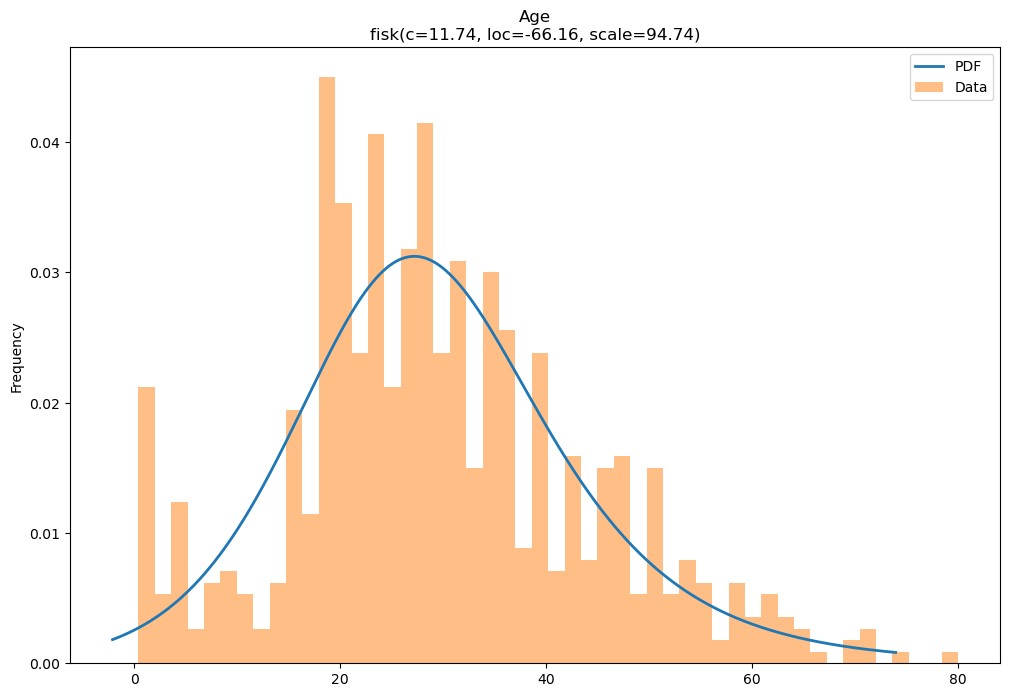

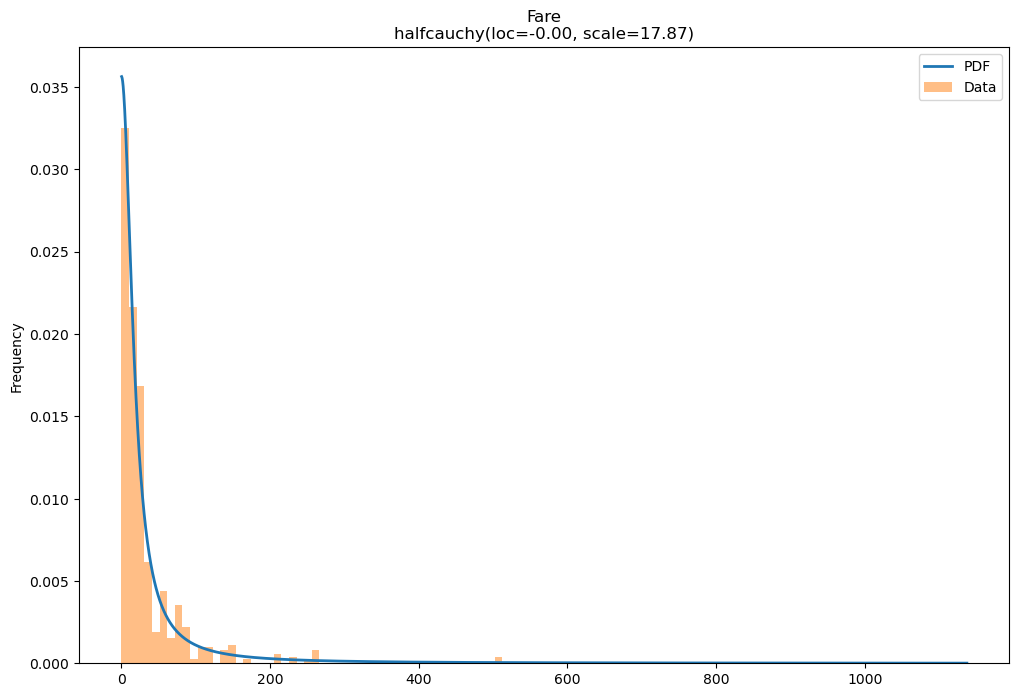

In [29]:
plot_result(df, continuous, cts_best_distributions)

In [30]:
# Create one single function
def generate_like_df(df, categorical_cols, continuous_cols, cts_best_distributions, n, seed=0):
    np.random.seed(seed)
    d = {}

    for c in categorical_cols:
        counts = df[c].value_counts()
        d[c] = np.random.choice(list(counts.index), p=(counts/len(df)).values, size=n)

    for c, bd in zip(continuous_cols, cts_best_distributions):
        dist = getattr(st, bd[0])
        d[c] = dist.rvs(size=n, *bd[1])

    return pd.DataFrame(d, columns=categorical_cols+continuous_cols)

In [31]:
# Apply the function
new_df = generate_like_df(df, categorical, continuous, cts_best_distributions, n=100)
new_df.shape
new_df.head()

(100, 8)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age,Fare
0,0,1,1,1,0,2,16.846655,11.866699
1,1,3,0,1,2,2,22.967661,6.523808
2,1,1,1,0,0,2,34.873726,2.272420
3,0,2,1,0,2,2,9.149005,2.408852
4,0,3,1,0,1,2,32.161475,6.477172


In [32]:
# Round Age and Fare to 3d.p
new_df['Age'] = new_df['Age'].round(3)
new_df['Fare'] = new_df['Fare'].round(3)
new_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age,Fare
0,0,1,1,1,0,2,16.847,11.867
1,1,3,0,1,2,2,22.968,6.524
2,1,1,1,0,0,2,34.874,2.272
3,0,2,1,0,2,2,9.149,2.409
4,0,3,1,0,1,2,32.161,6.477


In [33]:
# Replace column names with numbers
new_df.columns = list(range(new_df.shape[1]))
new_df.head()

,0,1,2,3,4,5,6,7
0,0,1,1,1,0,2,16.847,11.867
1,1,3,0,1,2,2,22.968,6.524
2,1,1,1,0,0,2,34.874,2.272
3,0,2,1,0,2,2,9.149,2.409
4,0,3,1,0,1,2,32.161,6.477


In [34]:
# The data is now anonymized
new_df.to_csv("C:/Users/User/Documents/UNI/4th year/1st sem/Big Data/new_titanic.csv", index_label="id")